# LRP for regression: A simulation study

```
Simon M. Hofmann
Max Planck for Human and Cognitive Sciences, Leipzig, Germany

<[firstname].[lastname][at]pm.me>
2021, Apri 1
```

![IMG](../Pumpkin.jpg)

## Import packages and modules <a class="tocSkip">

In [1]:
# Notebook related
import qgrid
from IPython.display import display, Image

# xdlreg
import xdlreg
from xdlreg.run_simulation import run_simulation

# Packages
import os
import inspect
import string
from skimage import draw
import matplotlib.pyplot as plt
import seaborn as sns
import concurrent.futures
import keras
from scipy import stats



Using TensorFlow backend.


## Run full simulation pipeline

In [ ]:
# Here for non-uniform dataset
run_simulation(path="..", n_samples=2000, uniform=Fals, target_bias=55., epochs=80, plot_n_heatmaps=20)

## Get simulation data

In [2]:
# # Information about the underyling functions
# print(inspect.getsource(PumpkinSet))
# print(inspect.getsource(get_pumpkin_set))

# Get Pumpkin dataset
uniform_pumpkins = get_pumpkin_set(n_samples=2000, uniform=True)
nonuniform_pumpkins = get_pumpkin_set(n_samples=2000, uniform=False)

Found & load following file: 2020-09-29_18-54_N-2000_uniform.pkl ...

Processing time of load_obj: 0:00:01 [h:m:s]
Found & load following file: 2020-09-29_19-22_N-2000_non-uniform.pkl ...

Processing time of load_obj: 0:00:01 [h:m:s]


### Explore data

In [3]:
# print(*[prop for prop in dir(uniform_pumpkins) if "__" not in prop], sep="\n")  # what does the class PumpkinSet contain
cprint(f"Dataset name: {uniform_pumpkins.name}", 'b')
print("Number of samples:", uniform_pumpkins.n_samples)
print("Age Distrubtion:", uniform_pumpkins.age_distribution)

Dataset name: 2020-09-29_18-54_N-2000_uniform
Number of samples: 2000
Age Distrubtion: [23 21 31 ... 47 44 53]


#### A sample pumpkin

Hi, I am PHvOg082655289 and I am 23 years old.
Number of atrophies: 116
Number of lesions: 0
Image.shape: (98, 98)


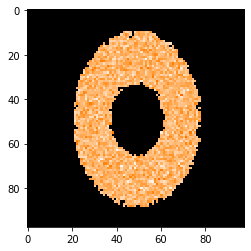

In [8]:
# # Take one pumpkin
phead = uniform_pumpkins.data[0]  # class PumpkinHead 
# print(inspect.getsource(PumpkinHead))
# print(*[prop for prop in dir(phead) if "__" not in prop], sep="\n")  # what does the class PumpkinHead contain
# print(*vars(phead).keys(), sep="\n")

def introduce_yourself(pumpkin):
    cprint(f"Hi, I am {pumpkin.name} and I am {pumpkin.age} years old.", 'y')

introduce_yourself(phead)
print("Number of atrophies:", phead.n_atrophies)  # class PumpkinHead also includes the position of the atrophies & lesions
print("Number of lesions:", phead.n_lesions)
print("Image.shape:", phead.pumpkin_brain.shape)

# Plot the pumpkin
%matplotlib inline
phead.exhibition()

#### How do they grow?
First we need a standard pumpkin. This is a blue-print (with some slight variation) for each instantiation of a *real* pumpkin

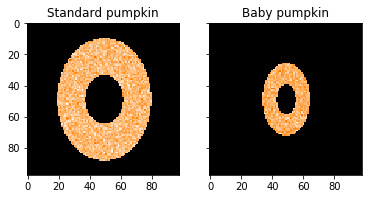

In [9]:
# print(inspect.getsource(make_pumpkin))

# Create standard pumpkin
standard_pumpkin = make_pumpkin(age=66)
standard_baby_pumpkin = make_pumpkin(age=2)

# Plot it
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.imshow(standard_pumpkin, cmap="gist_heat")
ax1.set_title("Standard pumpkin")
ax2.imshow(standard_baby_pumpkin, cmap="gist_heat")
ax2.set_title("Baby pumpkin")
plt.show()

# # Image intensities
# _ = plt.hist(standard_pumpkin.flatten(), log=True, bins=200)

We let the pumpkin grow with the class `PumpkinHead`

In [10]:
# Explore the class PumpkinHead 
print(inspect.getsource(PumpkinHead))

class PumpkinHead:
    def __init__(self, age, name=None):
        self.age = age
        self.name = random_name() if name is None else name
        self.pumpkin_brain = make_pumpkin(age=age)
        self.n_lesions = None
        self.lesion_coords = []
        self.n_atrophies = None
        self.atrophy_coords = []
        self.grow()

    def grow(self):
        """Run several ageing processes on self.pumpkin_brain ad function of self.age"""
        self.add_lesions()
        self.add_atrophies()

    def add_atrophies(self, **kwargs):
        """
        Atrophies are probabilistically applied to surface area including inner surfaces
        Reduce image intensity in a certain range up to zero (i.e. maximal reduction)
        """

        max_atrophies = max_age * kwargs.pop("max_atrophies", 5)  # keep max_age here to clip below
        expected_n_atrophies = max_atrophies * self.age/max_age

        # Compute normal (int) distrubtion around expected value
        distr = np.round

Hi, I am Halloween senior and I am 77 years old.


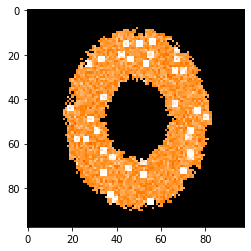

Hi, I am Halloween junior and I am 22 years old.


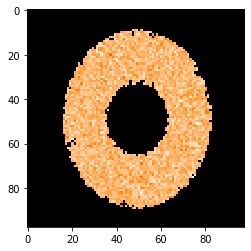

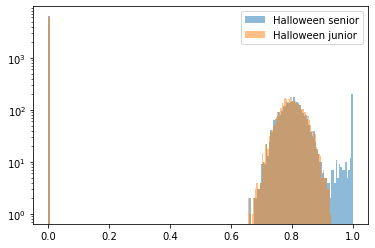

In [11]:
# Oldy
pumpy = PumpkinHead(age=77, name="Halloween senior")
introduce_yourself(pumpy)
pumpy.exhibition()

# Youngster
pumpster = PumpkinHead(age=22, name="Halloween junior")
introduce_yourself(pumpster)
pumpster.exhibition()

# Image intensities
_ = plt.hist(pumpy.pumpkin_brain.flatten(), bins=200, log=True, label=pumpy.name, alpha=.5)
_ = plt.hist(pumpster.pumpkin_brain.flatten(), bins=200, log=True, label=pumpster.name, alpha=.5)
plt.legend()
plt.show()

#### Data distrubtion

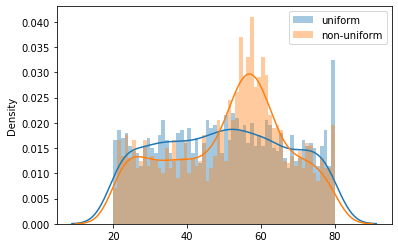

In [8]:
# Plot data distrubtion
plt.figure()
sns.distplot(a=uniform_pumpkins.age_distribution, bins=max_age - min_age, kde=True, label="uniform")
sns.distplot(a=nonuniform_pumpkins.age_distribution, bins=max_age - min_age, kde=True, label="non-uniform")
plt.legend()
plt.show()

#### Number of lesions & atrophies
Both the number of lesions and atrophies is a function of age

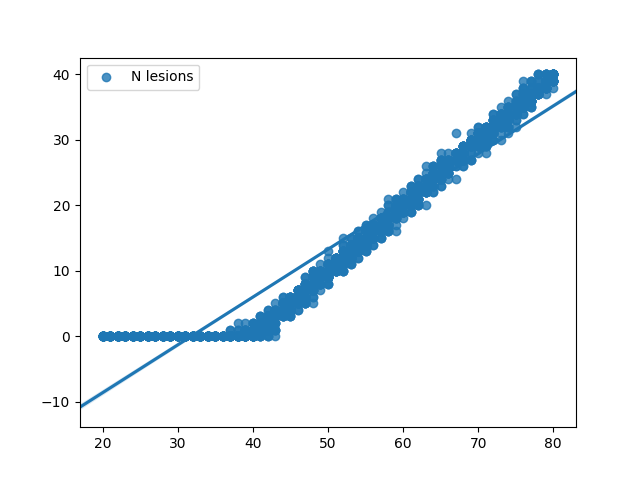

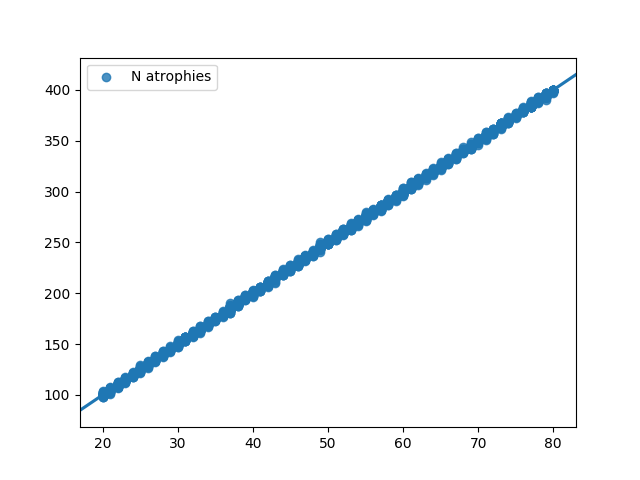

In [9]:
display(Image(filename=os.path.join(p2simulation, "lesions_vs_age_uni.png")))
# display(Image(filename=os.path.join(p2simulation, "lesions_vs_age_non-uni.png")))  # SAME
display(Image(filename=os.path.join(p2simulation, "atrophies_vs_ageuni.png")))
# display(Image(filename=os.path.join(p2simulation, "atrophies_vs_agenon-uni.png")))  # SAME

## Get prediction model

In [12]:
# print(inspect.getsource(create_simulation_model))
def get_trained_simulation_model(uniform=True):
    return keras.models.load_model(p2simulation + f"PumpkinNet_ReLU_{'' if uniform else 'non-'}uniform_final.h5")    

In [13]:
# Set globally 
uniform=False

# Load model
model = get_trained_simulation_model(uniform=uniform)






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 98, 98, 16)        160       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 49, 49, 16)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 49, 49, 16)        2320      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 25, 25, 16)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 25, 25, 32)        4640      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 13, 13, 64)        18496     
__________

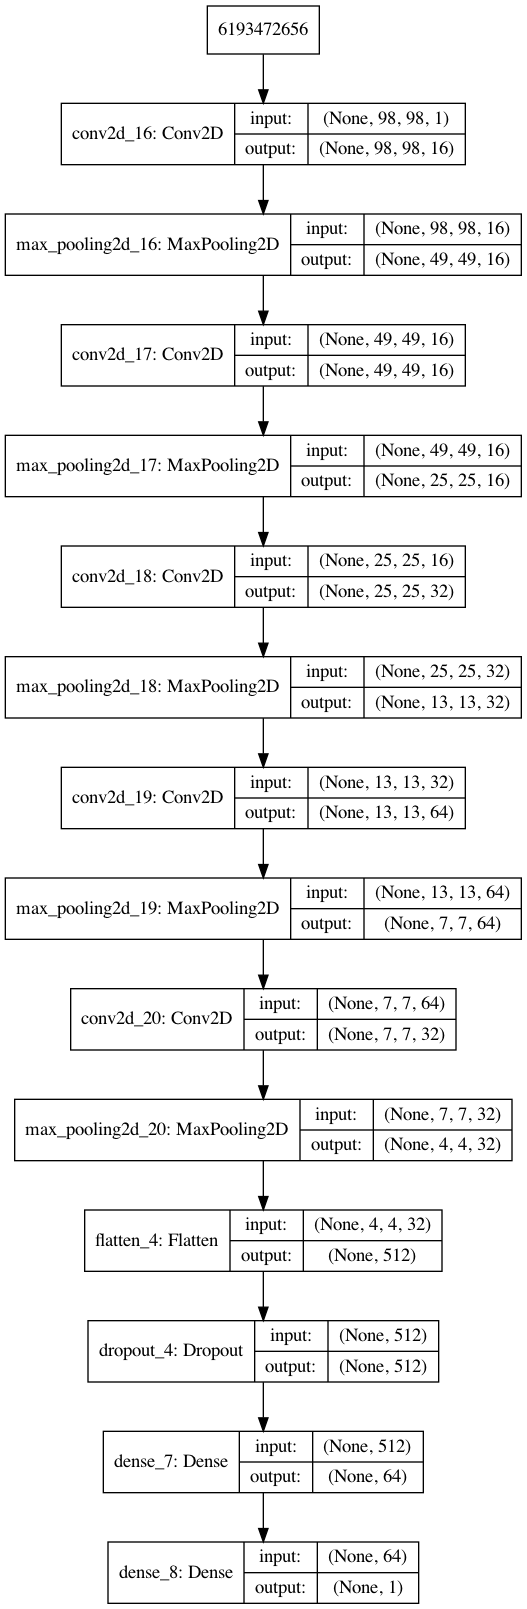

In [14]:
# Model Summary
model.summary()

# Plot model
plot_name = f"{p2simulation}{model.name}.png"
keras.utils.plot_model(model=model, to_file=plot_name, show_shapes=True)
cprint("\nModel plot\n", 'b')
display(Image(filename=plot_name))

### Training process

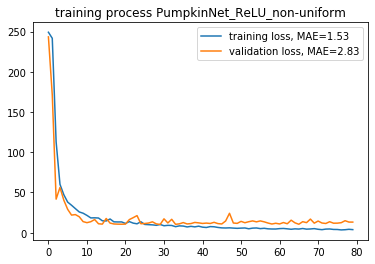

In [15]:
training_process = np.load(f"{p2simulation}{model.name}_history.npy", allow_pickle=True).item()

# Plot training process
plt.title(f"training process {model.name}")
plt.plot(training_process["loss"], label=f"training loss, MAE={training_process['mean_absolute_error'][-1]:.2f}")
plt.plot(training_process["val_loss"], label=f"validation loss, MAE={training_process['val_mean_absolute_error'][-1]:.2f}")
plt.legend()

### Model performance

In [16]:
# Prep data as model input
x, y = uniform_pumpkins.data2numpy(for_keras=True) if uniform else nonuniform_pumpkins.data2numpy(for_keras=True)
xtest, ytest = split_simulation_data(xdata=x, ydata=y, only_test=True)

# Predict on test set:
preds = model.predict(xtest)

# Model performance
perform = np.mean(np.abs(preds.squeeze() - ytest))
r, _ = stats.pearsonr(preds.flatten(), ytest)  # r, p

cprint(f"\n{model.name} has a MAE of {perform:.2f} ({ss('R2', sub=False)}={r**2:.2f})\n", 'b')

xdata.shape: (2000, 98, 98, 1)
ydata.shape: (2000,)

PumpkinNet_ReLU_non-uniform has a MAE of 2.80 (R²=0.95)



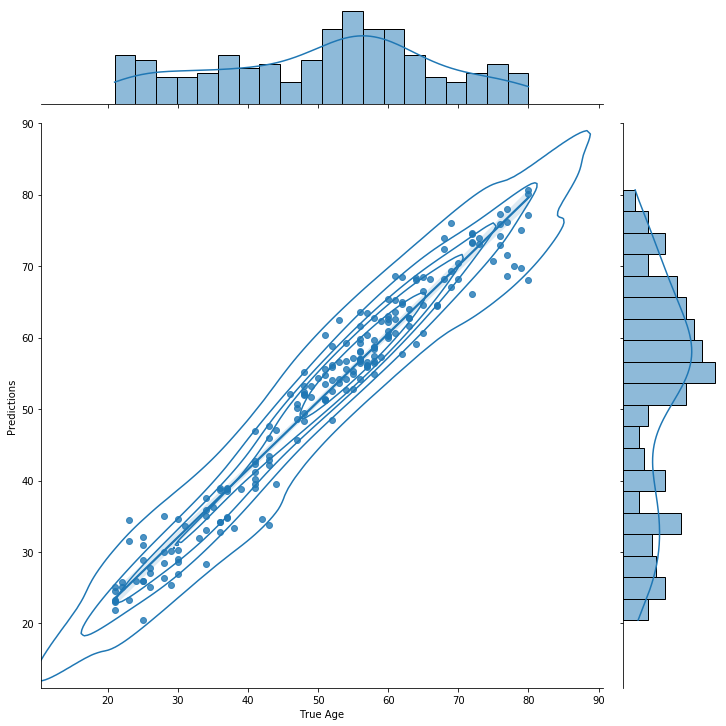

In [19]:
# Plot predictions 
sns.jointplot(x=ytest, y=preds.squeeze(), kind="reg", height=10,
              marginal_kws=dict(bins=int(round((ytest.max() - ytest.min()) / 3))),
              xlim=(np.min(preds) - 10, np.max(preds) + 10),
              ylim=(np.min(ytest) - 10, np.max(ytest) + 10)).plot_joint(
    sns.kdeplot, zorder=0, n_levels=6).set_axis_labels("True Age", "Predictions")

## Apply LRP analysis

In [20]:
# Model output bias is important for the interpretation of the following relevance maps
model_output_bias = model.layers[-1].get_weights()[1].item()

# Compare to mean age in dataset and prediction-'bias'
cprint(f"Model output bias is: {model_output_bias:.2f}", 'b')
print(f"Mean age of dataset is: {ytest.mean():.2f}")
cprint(f"Mean prediction on test set is: {preds.mean():.2f}", 'y')

Model output bias is: 51.03
Mean age of dataset is: 50.88
Mean prediction on test set is: 51.90


LRP_S0_age-21.0_pred-23.3


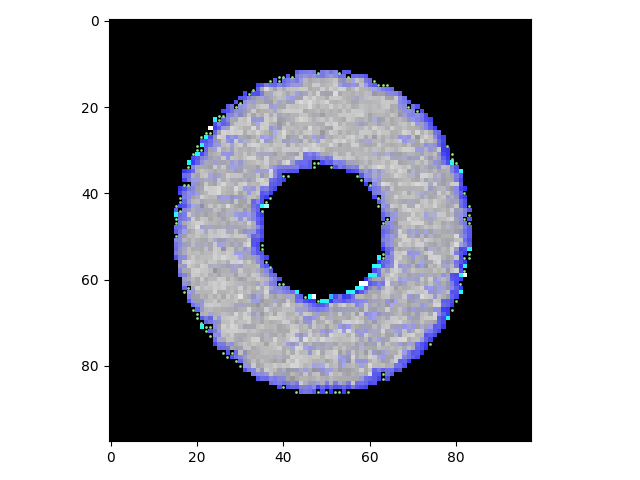

LRP_S10_age-22.0_pred-25.1


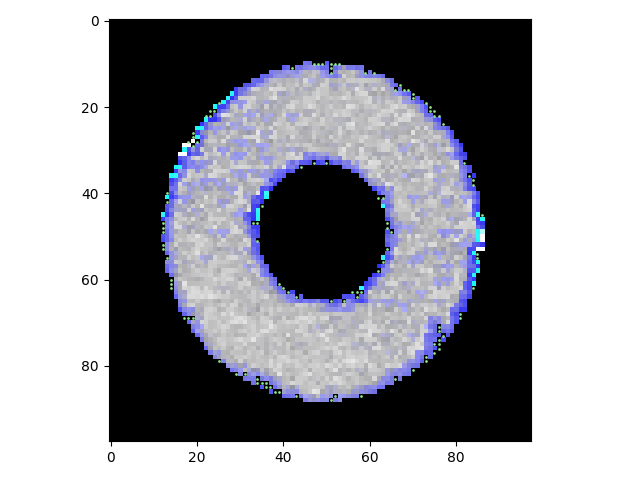

LRP_S7_age-41.0_pred-46.9


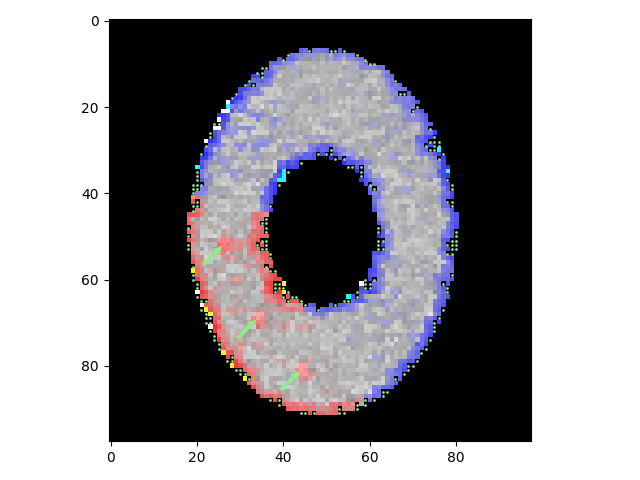

LRP_S16_age-43.0_pred-42.9


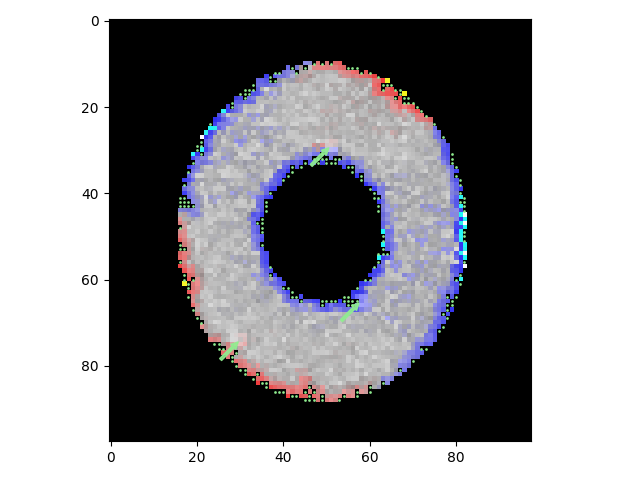

LRP_S9_age-47.0_pred-45.7


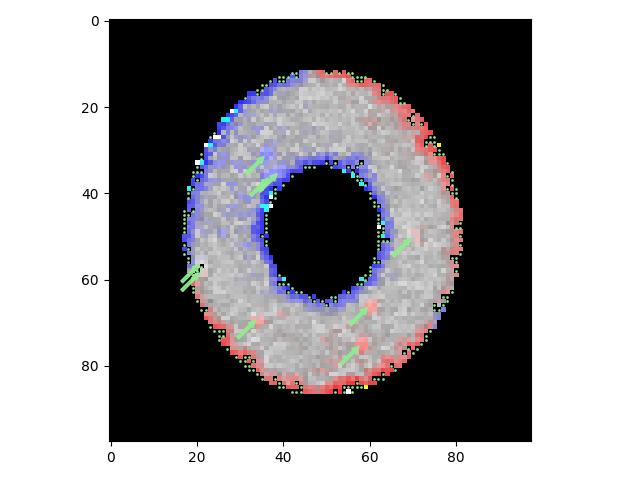

LRP_S14_age-49.0_pred-51.7


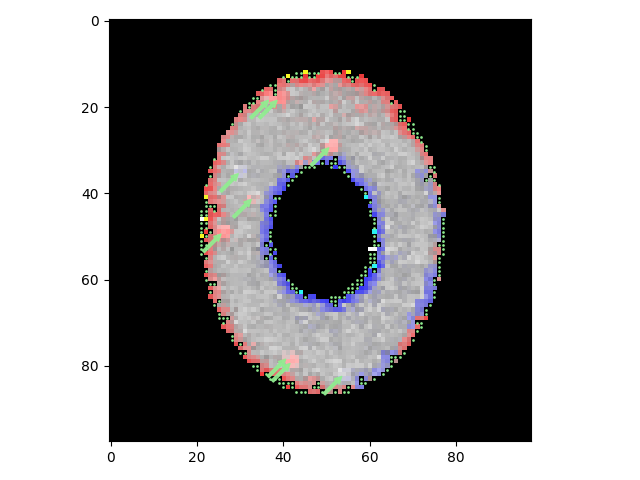

LRP_S18_age-50.0_pred-54.4


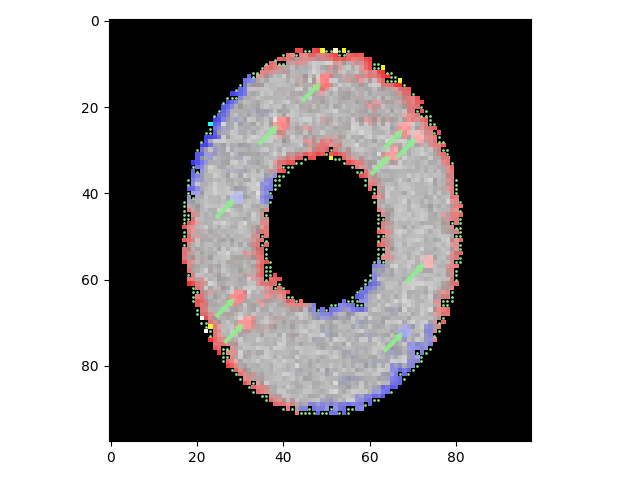

LRP_S11_age-52.0_pred-48.5


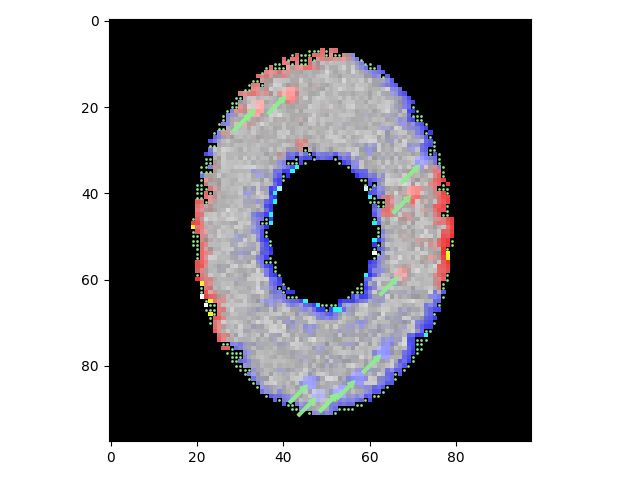

LRP_S17_age-52.0_pred-58.8


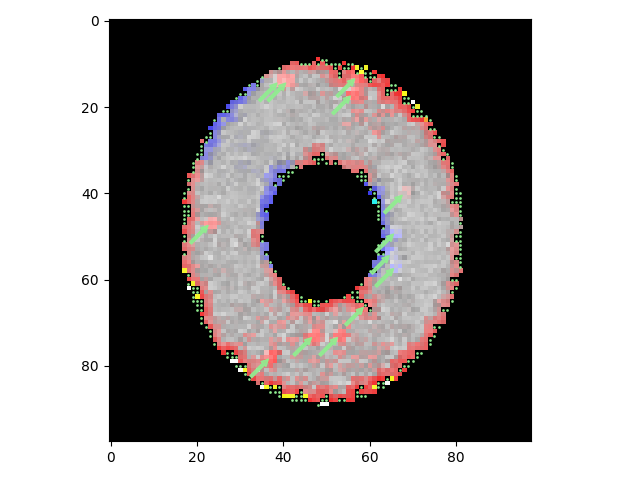

LRP_S5_age-55.0_pred-57.1


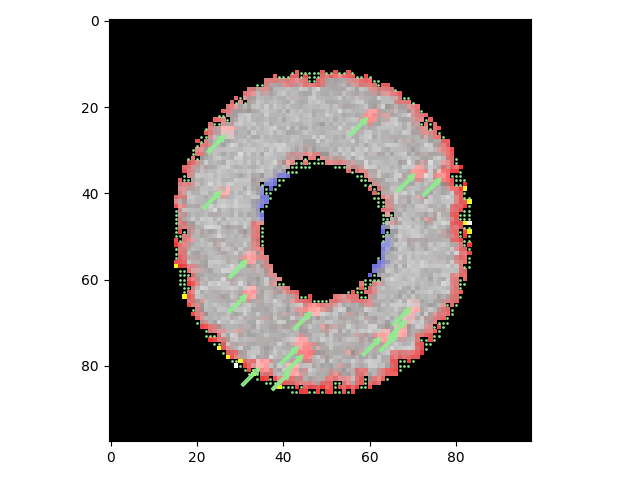

LRP_S15_age-56.0_pred-57.0


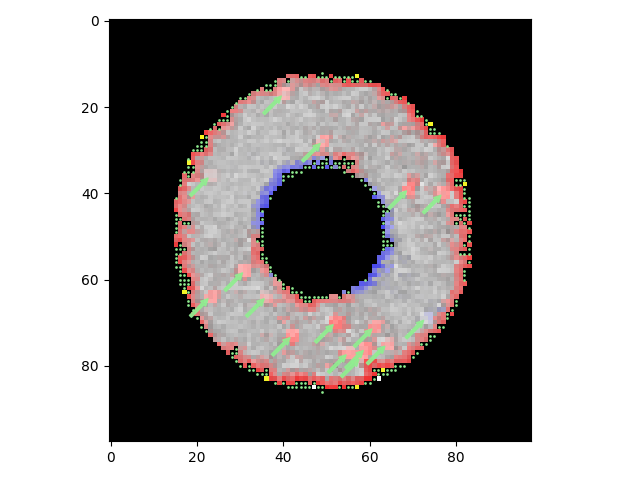

LRP_S8_age-56.0_pred-56.9


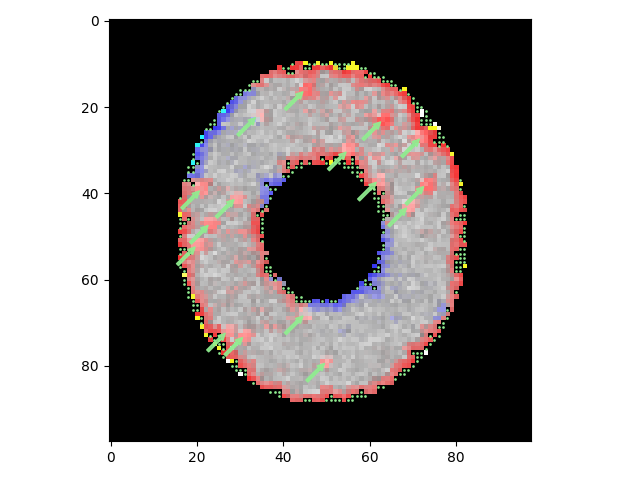

LRP_S6_age-56.0_pred-56.7


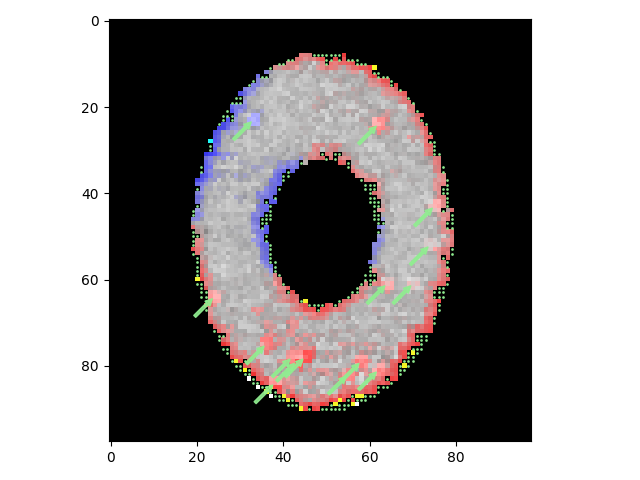

LRP_S1_age-58.0_pred-58.8


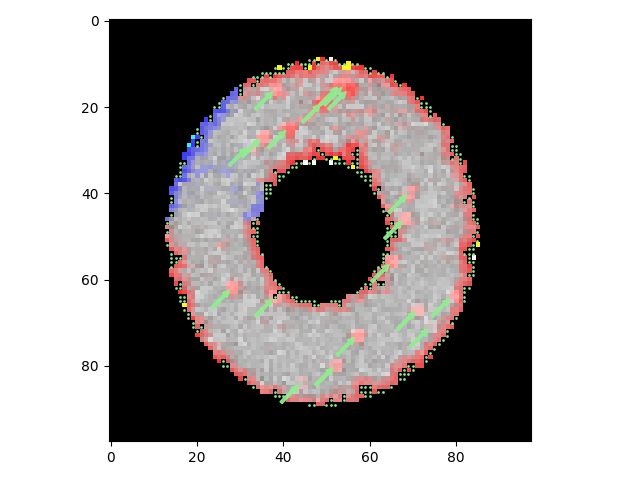

LRP_S12_age-58.0_pred-59.7


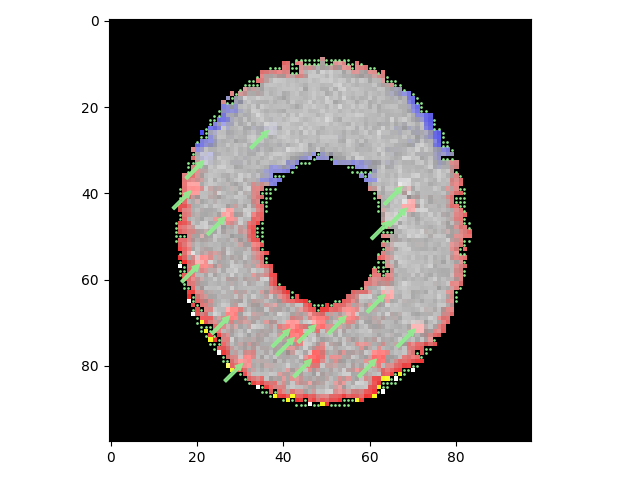

LRP_S4_age-60.0_pred-62.2


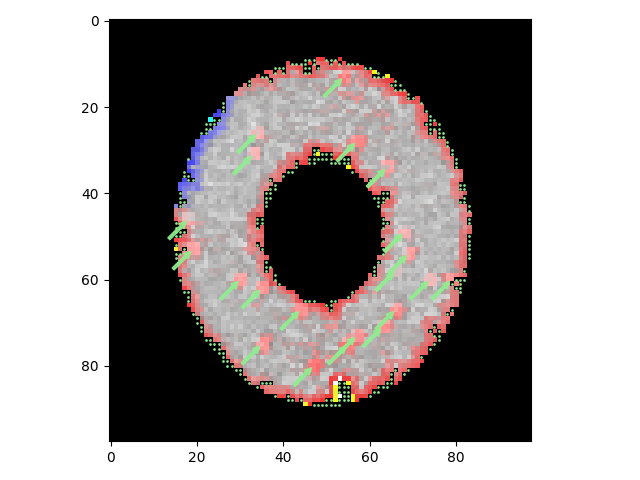

LRP_S13_age-61.0_pred-65.3


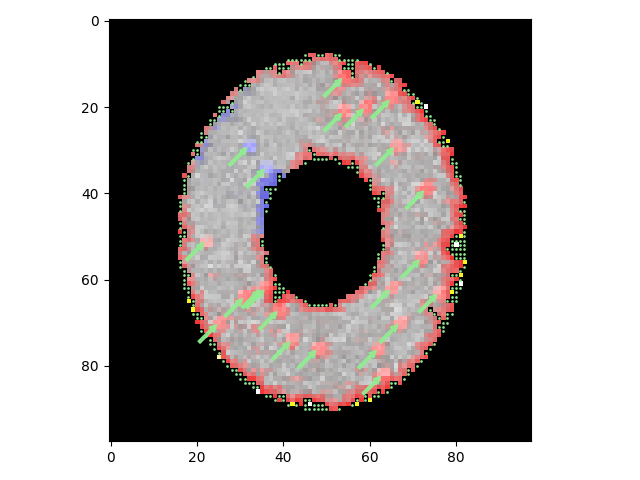

LRP_S19_age-63.0_pred-62.8


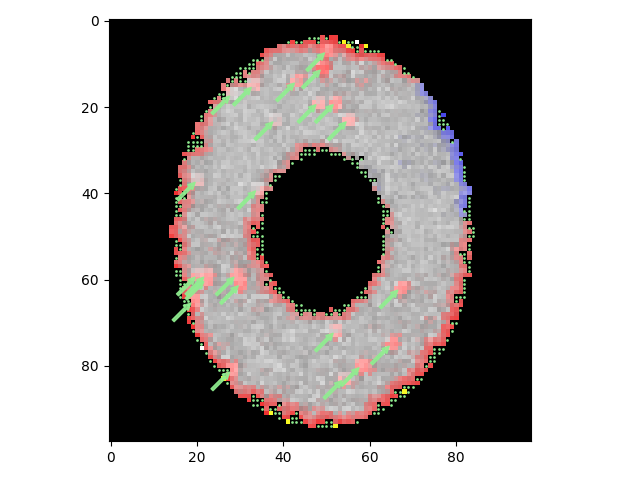

LRP_S3_age-79.0_pred-75.0


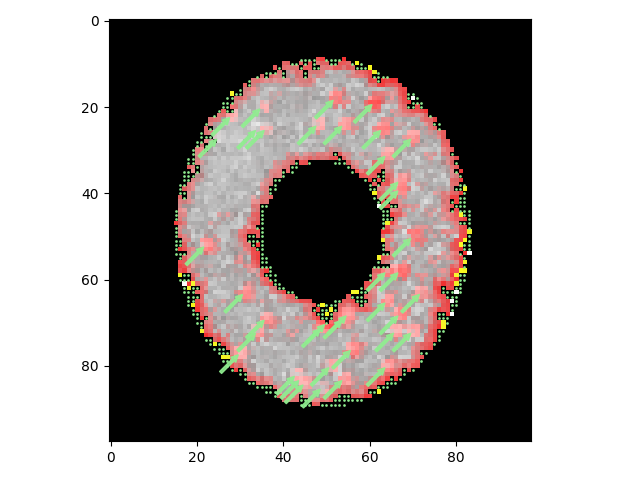

LRP_S2_age-80.0_pred-68.1


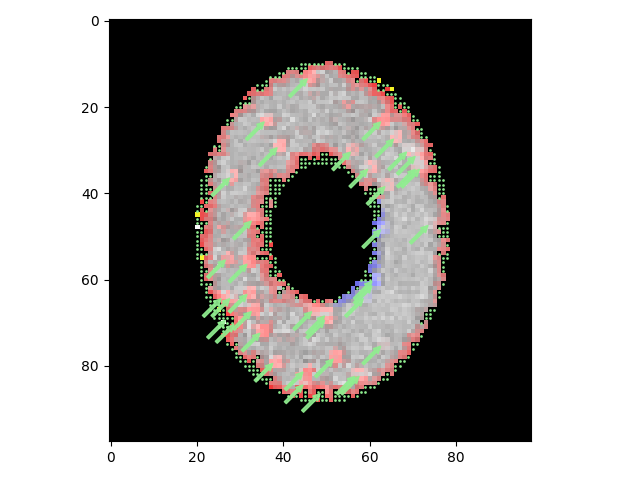

Sum_relevance_over_Predictio


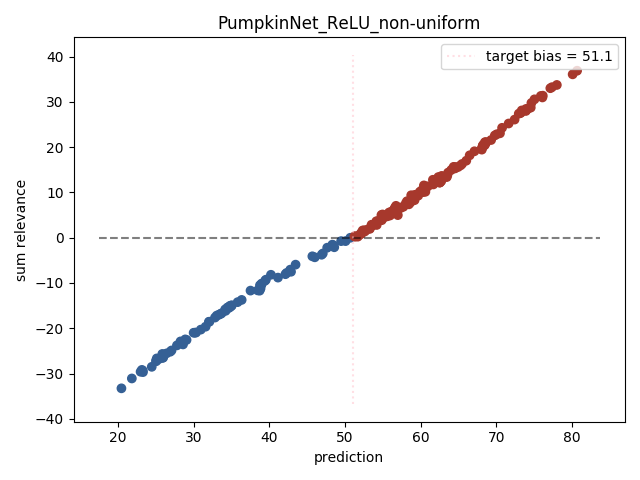

In [21]:
# # Get already computed LRP heatmaps of 20 subjects 
# print(inspect.getsource(plot_simulation_heatmaps))
list_of_LRP_images = os.listdir(p2simulation + model.name)
list_of_LRP_images = [name for name in list_of_LRP_images if ".png" in name]  # remove non-*.png's
list_of_ages = [name.split("_")[2] for name in list_of_LRP_images]  # get age information from list
sorted_list_of_LRP_images = np.array(list_of_LRP_images)[np.argsort(list_of_ages)]  # get sort index w.r.t age

# Display LRP heatmaps
for LRP_image_file in sorted_list_of_LRP_images:
    if ".png" in LRP_image_file:
        cprint(LRP_image_file.rstrip(".png"), 'b')
        display(Image(filename=os.path.join(p2simulation, model.name, LRP_image_file)))